In [1]:
import pandas as pd

df = pd.read_csv("../data/combined_cluster_edges_w_arguments_location.csv")

## Top PageRank and Betweness Centrality Nodes

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Get all unique trigger texts
all_triggers = pd.Series(pd.concat([df['source_trigger'], df['target_trigger']]).dropna().unique())

# Use a pretrained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective
embeddings = model.encode(all_triggers.tolist(), show_progress_bar=True)

2025-04-11 09:53:34.267794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 09:53:34.913584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative clustering with cosine similarity
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.3,  # tweak this threshold based on desired granularity
    affinity='cosine',
    linkage='average'
)
labels = clustering.fit_predict(embeddings)

# Assign each cluster a canonical label (first item in cluster)
cluster_to_label = {}
for label in set(labels):
    cluster_items = all_triggers[labels == label]
    cluster_to_label[label] = cluster_items.iloc[0]  # or use custom merging logic

# Build mapping: original → merged
merge_map = dict(zip(all_triggers, [cluster_to_label[l] for l in labels]))


# Group similar events based on the merge_map
from collections import defaultdict
# Build inverse mapping: canonical trigger → list of original triggers
clustered_events = defaultdict(list)
for original, merged in merge_map.items():
    clustered_events[merged].append(original)

# Convert to a printable sorted dictionary
clustered_events = dict(sorted(clustered_events.items(), key=lambda x: x[0]))

import pandas as pd
cluster_df = pd.DataFrame([
    {"Merged Label": merged, "Grouped Events": group}
    for merged, group in clustered_events.items()
])


/home/user/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [5]:
cluster_df["Grouped_events_len"] = cluster_df["Grouped Events"].apply(lambda x:len(x))

In [6]:
pd.set_option("max.colwidth",0)

In [7]:
cluster_df[cluster_df.Grouped_events_len>1]

,Merged Label,Grouped Events,Grouped_events_len
2,10 per cent tariffs on all Chinese imports,"[10 per cent tariffs on all Chinese imports, impose an additional 10 per cent tariff, impose a 10 per cent tariff on Chinese goods]",3
3,2016 ruling of an international arbitral tribunal,"[2016 ruling of an international arbitral tribunal, 2016 ruling by the Permanent Court of Arbitration]",2
13,China banned all seafood imports,"[China banned all seafood imports, Chinese ban of Japanese seafood imports]",2
16,China has ramped up military exercises,"[China has ramped up military exercises, Chinese military drills, stepped up Chinese military activity]",3
21,China's maritime claims,"[China's maritime claims, maritime claims]",2
36,Jake Sullivan’s trip to Beijing,"[Jake Sullivan’s trip to Beijing, Jake Sullivan held several days of talks in Beijing]",2
42,October 7 attack by Islamist Hamas militants,"[October 7 attack by Islamist Hamas militants, Hamas attack on Israel]",2
48,Russia's invasion of Ukraine,"[Russia's invasion of Ukraine, Russia's war on Ukraine continues]",2
54,TikTok stopped working,"[TikTok stopped working, revive TikTok access]",2
60,US President Joe Biden to meet Xi Jinping,"[US President Joe Biden to meet Xi Jinping, US President Joe Biden and Chinese President Xi Jinping are expected to meet]",2


In [8]:
df['source_trigger'] = df['source_trigger'].map(merge_map)
df['target_trigger'] = df['target_trigger'].map(merge_map)

In [9]:
df[df['source_trigger'].apply(len) < 10][["source_trigger"]]


,source_trigger
17,arrived
394,met
395,met
396,met
397,met
398,met


In [10]:
invalid_triggers = ["arrived","met"]
df = df[~df.source_trigger.isin(invalid_triggers)]
df = df[~df.target_trigger.isin(invalid_triggers)]

In [11]:
df = df[df.source_trigger!=df.target_trigger]

In [12]:
from pyvis.network import Network
import networkx as nx

def get_topk_page_rank_nodes(df, top_n=10, filename="event_graph_pyvis.html"):
    # Step 1: Build NetworkX graph
    G = nx.DiGraph()
    for _, row in df.iterrows():
        src = row['source_trigger']
        tgt = row['target_trigger']
        if pd.notna(src) and pd.notna(tgt):
            G.add_edge(src, tgt)

    # Step 2: PageRank for influence
    pagerank = nx.pagerank(G)
    top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = set(node for node, _ in top_nodes)

    return  G, top_nodes

In [13]:
G, top_nodes = get_topk_page_rank_nodes(df, top_n=10)
for rank, (trigger, score) in enumerate(top_nodes, 1):
    print(f"{rank}. {trigger} — PageRank Score: {score:.4f}")

1. China banned all seafood imports — PageRank Score: 0.0170
2. US President Joe Biden to meet Xi Jinping — PageRank Score: 0.0140
3. release of treated water — PageRank Score: 0.0126
4. territorial disputes in the South China Sea — PageRank Score: 0.0126
5. threatened to slap a 60 per cent flat fee on Chinese goods — PageRank Score: 0.0122
6. slowing economy — PageRank Score: 0.0118
7. tensions between the US and China are high — PageRank Score: 0.0101
8. meetings with Tesla CEO Elon Musk and other US business leaders — PageRank Score: 0.0098
9. trade war threat — PageRank Score: 0.0091
10. started a trade war with China — PageRank Score: 0.0090


In [14]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

def plot_clusters_pyvis(df, top_triggers, depth=1, filename="event_clusters_pyvis.html"):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        src, tgt = row['source_trigger'], row['target_trigger']
        if pd.notna(src) and pd.notna(tgt):
            G.add_edge(src, tgt)

    # Compute centrality metrics
    pagerank = nx.pagerank(G)
    betweenness = nx.betweenness_centrality(G)

    # Normalize betweenness (to be between 0 and 1)
    max_bc = max(betweenness.values()) if betweenness else 1e-6
    norm_bc = {k: v / max_bc for k, v in betweenness.items()}

    # Use 10 matplotlib tab10 colors for clusters
    available_colors = plt.cm.tab10.colors
    color_list = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b in available_colors]
    color_map = {}

    # Build node clusters
    clusters = {}
    for i, trigger in enumerate(top_triggers):
        color = color_list[i % len(color_list)]
        color_map[trigger] = color

        if trigger in G.nodes:
            neighbors = set([trigger])
            if depth >= 1:
                neighbors.update(G.successors(trigger))
                neighbors.update(G.predecessors(trigger))
            if depth == 2:
                for n in list(neighbors):
                    neighbors.update(G.successors(n))
                    neighbors.update(G.predecessors(n))

            for node in neighbors:
                clusters[node] = (trigger, color)

    # Create Pyvis graph
    net = Network(height="800px", width="100%", directed=True)
    net.force_atlas_2based()

    for node in clusters.keys():
        trigger, color = clusters[node]
        pr = pagerank.get(node, 0)
        bc = norm_bc.get(node, 0)

        # Combine PageRank and Betweenness for node size
        combined_score = pr + bc  # You can adjust weighting if needed
        size = 20 + combined_score * 50  # Scaled up for visibility

        short_label = ' '.join(node.split()[:2]) + "…" if len(node.split()) > 2 else node
        net.add_node(
            node,
            label=short_label,
            title=f"{node}<br>PageRank: {pr:.4f}<br>Betweenness: {betweenness.get(node, 0):.4f}<br>Cluster: {trigger}",
            size=size,
            color=color
        )

    for src, tgt in G.edges():
        if src in clusters and tgt in clusters:
            net.add_edge(src, tgt)

    net.show_buttons(filter_=['physics'])
    net.write_html(filename)
    print(f"Enhanced Pyvis graph saved to: {filename}")


In [15]:
top_triggers = [d[0] for d in top_nodes]

plot_clusters_pyvis(df, top_triggers, depth=1)

Enhanced Pyvis graph saved to: event_clusters_pyvis.html


## Narrative Tree Analysis from Initial Nodes

In [16]:
import networkx as nx
import pandas as pd

# Step 1: Find nodes with no incoming edges (roots)
initial_nodes = [node for node in G.nodes if G.in_degree(node) == 0]


In [17]:
def analyze_narrative_tree(G, root):
    descendants = nx.descendants(G, root)
    subgraph = G.subgraph(descendants | {root}).copy()
    
    # BFS to calculate depth
    depth_dict = {root: 0}
    queue = [(root, 0)]
    visited = set([root])

    while queue:
        node, depth = queue.pop(0)
        for neighbor in G.successors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                depth_dict[neighbor] = depth + 1
                queue.append((neighbor, depth + 1))

    return {
        "initial_event": root,
        "total_influenced": len(descendants),
        "max_depth": max(depth_dict.values()) if depth_dict else 0
    }

# Step 3: Run for all initial nodes
narrative_stats = [analyze_narrative_tree(G, node) for node in initial_nodes]
df_narratives = pd.DataFrame(narrative_stats).sort_values(by="total_influenced", ascending=False)


In [18]:
def get_influence_metrics(G, root):
    descendants = nx.descendants(G, root)
    subgraph = G.subgraph(descendants | {root}).copy()
    depths = {}

    # BFS for depth
    queue = [(root, 0)]
    visited = set()
    while queue:
        current, depth = queue.pop(0)
        if current not in visited:
            depths[current] = depth
            visited.add(current)
            for neighbor in G.successors(current):
                queue.append((neighbor, depth + 1))

    return {
        "trigger_event": root,
        "total_influenced": len(descendants),
        "max_depth": max(depths.values()) if depths else 0
    }
results = [get_influence_metrics(G, node) for node in initial_nodes]
df_influence = pd.DataFrame(results).sort_values(by="total_influenced", ascending=False)

In [19]:
results = [get_influence_metrics(G, node) for node in initial_nodes]
df_influence = pd.DataFrame(results).sort_values(by="total_influenced", ascending=False)

In [20]:
df_influence

,trigger_event,total_influenced,max_depth
55,largest navy fleet in nearly three decades,50,8
13,Lai Ching-te's rhetoric defending sovereignty,50,9
34,revives Cold War submarine spy programme,50,7
2,new US sanctions,44,6
76,lashes out,32,4
...,...,...,...
35,oil prices eased,1,1
32,severed diplomatic links with Taiwan,1,1
31,urged to put the interests of the people first and cease fire,1,1
30,fusion breakthrough called ignition,1,1


In [21]:
from pyvis.network import Network

def visualize_narrative_tree(G, root, pagerank, clusters, filename_prefix="narrative_tree"):
    descendants = nx.descendants(G, root)
    subgraph = G.subgraph(descendants | {root}).copy()

    net = Network(height="600px", width="100%", directed=True)
    net.force_atlas_2based()

    for node in subgraph.nodes():
        pr = pagerank.get(node, 0)
        label = ' '.join(node.split()[:3]) + "…" if len(node.split()) > 3 else node
        cluster_label, color = clusters.get(node, ("Unclustered", "#cccccc"))

        net.add_node(
            node,
            label=label,
            title=f"{node}<br>PageRank: {pr:.4f}<br>Cluster: {cluster_label}",
            size=20 + pr * 150,
            color=color
        )

    for src, tgt in subgraph.edges():
        net.add_edge(src, tgt)

    filename = f"{filename_prefix}_{root[:10].replace(' ', '_')}.html"
    net.write_html(filename)
    print(f"Saved: {filename}")


In [22]:
import networkx as nx

pagerank = nx.pagerank(G)
import matplotlib.pyplot as plt


# Example: Top trigger nodes (you can modify this list)
top_triggers =df_influence["trigger_event"][:10]

# top_triggers= ["new US sanctions"]

# Setup cluster colors
available_colors = plt.cm.tab10.colors
color_list = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b in available_colors]
color_map = {}
clusters = {}

# Build clusters using graph neighborhood
depth = 1  # or 2 if you want larger neighborhoods
for i, trigger in enumerate(top_triggers):
    color = color_list[i % len(color_list)]
    color_map[trigger] = color

    if trigger in G.nodes:
        neighbors = set([trigger])
        if depth >= 1:
            neighbors.update(G.successors(trigger))
            neighbors.update(G.predecessors(trigger))
        if depth == 2:
            for n in list(neighbors):
                neighbors.update(G.successors(n))
                neighbors.update(G.predecessors(n))

        for node in neighbors:
            clusters[node] = (trigger, color)


In [23]:
df_narratives.head(10)

,initial_event,total_influenced,max_depth
55,largest navy fleet in nearly three decades,50,8
13,Lai Ching-te's rhetoric defending sovereignty,50,9
34,revives Cold War submarine spy programme,50,7
2,new US sanctions,44,6
76,lashes out,32,4
88,equated his Chinese counterpart Xi Jinping with 'dictators',31,4
86,China cutting off talks,31,4
83,barred some investment,30,6
71,Chinese automakers seek retaliatory tariffs on EU cars,30,6
48,vows of retaliation,28,5


In [59]:
# Top 3 narrative trees
top_roots = df_narratives.head(3)['initial_event'].tolist()
top_roots = ["new US sanctions"]

for root in top_roots:
    visualize_narrative_tree(G, root, pagerank, clusters)

Saved: narrative_tree_new_US_san.html


In [51]:
def find_all_paths_from_root(G, root, max_depth=5):
    unique_paths = set()
    for target in nx.descendants(G, root):
        for path in nx.all_simple_paths(G, source=root, target=target, cutoff=max_depth):
            unique_paths.add(tuple(path))  # Convert list to tuple to store in set
    return [list(p) for p in unique_paths]  # Convert back to list of lists

root_event = "new US sanctions"
paths = find_all_paths_from_root(G, root_event, max_depth=6)

print(f"Total paths from '{root_event}': {len(paths)}")
# Example: print first 3
for p in paths[:3]:
    print(" → ".join(p))


Total paths from 'new US sanctions': 98
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → stepped up its military and political pressure → authorises US$571 million in military aid to Taiwan
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → ramped up military activities → frequent military operations
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods → discussing a 10 per cent punitive duty


In [52]:
longest_path = max(paths, key=len)
print("\nLongest causal chain:")
print(" → ".join(longest_path))


Longest causal chain:
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → ramped up military activities → stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods → discussing a 10 per cent punitive duty


In [53]:
def find_all_paths_from_triggers(G, top_triggers, max_depth=5):
    all_paths = []
    for root in top_triggers:
        if root in G:
            for target in nx.descendants(G, root):
                for path in nx.all_simple_paths(G, source=root, target=target, cutoff=max_depth):
                    all_paths.append(path)
    return all_paths

# Example: your top_trigger list
top_triggers = [
    "new US sanctions"
]

# Get all paths starting from any top trigger
filtered_paths = find_all_paths_from_triggers(G, top_triggers, max_depth=6)

print(f"Total filtered paths: {len(filtered_paths)}")
for p in filtered_paths[:5]:
    print(" → ".join(p))


Total filtered paths: 98
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → ramped up military activities → stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods → US tariff hikes on Chinese imports
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods → sweeping tariffs on goods → US tariff hikes on Chinese imports
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods → US tariff hikes on Chinese imports
new US sanctions → US approves $515 million arms sale to Taiwan → discussed "China's military threats" → stepped up its military and political pressure → threatened 

In [58]:
from graphviz import Digraph

# Simulated input (filtered, unique causal chains)
extended_causal_chains = filtered_paths[:3]

# Create the decorated Graphviz flowchart
dot = Digraph(format='png')
dot.attr(rankdir='LR', size='20,10')

# Styling
node_style = {
    'shape': 'box',
    'style': 'filled',
    'color': 'lightgray',
    'fontname': 'Helvetica',
    'fontsize': '10'
}

node_ids = {}
counter = 0
edge_set = set()  # Track edges to avoid duplication

# Add nodes and edges from causal chains
for path in extended_causal_chains:
    for i, event in enumerate(path):
        if event not in node_ids:
            node_id = f"n{counter}"
            node_ids[event] = node_id
            counter += 1

            # Style first and last nodes
            if i == 0:
                dot.node(node_id, event, fillcolor='lightgreen', **node_style)
            elif i == len(path) - 1:
                dot.node(node_id, event, fillcolor='salmon', **node_style)
            else:
                dot.node(node_id, event, fillcolor='white', **node_style)

    for i in range(len(path) - 1):
        source, target = path[i], path[i + 1]
        edge_key = (source, target)
        if edge_key not in edge_set:
            dot.edge(node_ids[source], node_ids[target], color='gray', penwidth='1.2')
            edge_set.add(edge_key)

# Render and show
output_path = "unique_edges_causal_flowchart"
dot.render(output_path, view=False)
output_path += ".png"
output_path


'unique_edges_causal_flowchart.png'

In [65]:
start_candidates = [n for n in G.nodes() if G.in_degree(n) == 0]
end_candidates = [n for n in G.nodes() if G.out_degree(n) == 0]


In [67]:
from collections import Counter

def find_top_root_nodes(paths, top_k=5):
    starts = [p[0] for p in paths if len(p) > 1]
    return Counter(starts).most_common(top_k)

def find_top_target_nodes(paths, top_k=5):
    ends = [p[-1] for p in paths if len(p) > 1]
    return Counter(ends).most_common(top_k)

top_starts = find_top_root_nodes(paths)
top_ends = find_top_target_nodes(paths)

print("Top root events (event_A):", top_starts)
print("Top end events (event_B):", top_ends)


Top root events (event_A): [('new US sanctions', 98)]
Top end events (event_B): [('unveiled steep tariff increases', 5), ('started a trade war with China', 5), ('10 per cent tariffs on all Chinese imports', 5), ('tariff threat', 5), ('discussing a 10 per cent punitive duty', 4)]


In [68]:
pair_counter = Counter()

for path in paths:
    for i in range(len(path) - 1):
        pair = (path[i], path[i + 1])
        pair_counter[pair] += 1

# Top frequently occurring cause-effect pairs
print("Top cause-effect pairs:")
for pair, count in pair_counter.most_common(10):
    print(f"{pair[0]} → {pair[1]} (count: {count})")


Top cause-effect pairs:
new US sanctions → US approves $515 million arms sale to Taiwan (count: 90)
US approves $515 million arms sale to Taiwan → discussed "China's military threats" (count: 85)
stepped up its military and political pressure → threatened to slap a 60 per cent flat fee on Chinese goods (count: 67)
discussed "China's military threats" → stepped up its military and political pressure (count: 52)
discussed "China's military threats" → ramped up military activities (count: 27)
ramped up military activities → stepped up its military and political pressure (count: 21)
threatened to slap a 60 per cent flat fee on Chinese goods → sweeping tariffs on goods (count: 10)
threatened to slap a 60 per cent flat fee on Chinese goods → 10 per cent tariffs on all Chinese imports (count: 9)
threatened to slap a 60 per cent flat fee on Chinese goods → threatened to apply a tariff of 25 per cent (count: 7)
new US sanctions → tensions between the US and China are high (count: 7)


In [71]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Rebuild the graph G from causal chains
G = nx.DiGraph()
for path in filtered_paths:
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    G.add_edges_from(edges)

# Community detection using greedy modularity (converted to undirected for compatibility)
undirected_G = G.to_undirected()
communities = list(greedy_modularity_communities(undirected_G))

# Convert community sets to sorted lists for better readability
sorted_communities = [sorted(list(community)) for community in communities]

# Output first few communities
sorted_communities[:3]


[['10 per cent tariffs on all Chinese imports',
  '25 per cent tariff on all products from Mexico and Canada',
  'Beijing has vowed retaliation',
  'Trump has promised to impose sweeping tariffs',
  "Trump's 'America First' policy",
  'US tariff hikes on Chinese imports',
  'campaign to boycott China',
  'discussing a 10 per cent punitive duty',
  'started a trade war with China',
  'sweeping tariffs on goods',
  'tariff threat',
  'threatened to apply a tariff of 25 per cent',
  'threatened to slap a 60 per cent flat fee on Chinese goods',
  'trade war threat',
  'unveiled steep tariff increases',
  'would rather not impose tariffs'],
 ['$300 million sale',
  'China increased military pressure',
  'authorises US$571 million in military aid to Taiwan',
  'discussed "China\'s military threats"',
  'frequent military operations',
  'ramped up military activities',
  'received 38 advanced Abrams battle tanks',
  'stepped up its military and political pressure',
  'urged the US to stop sen

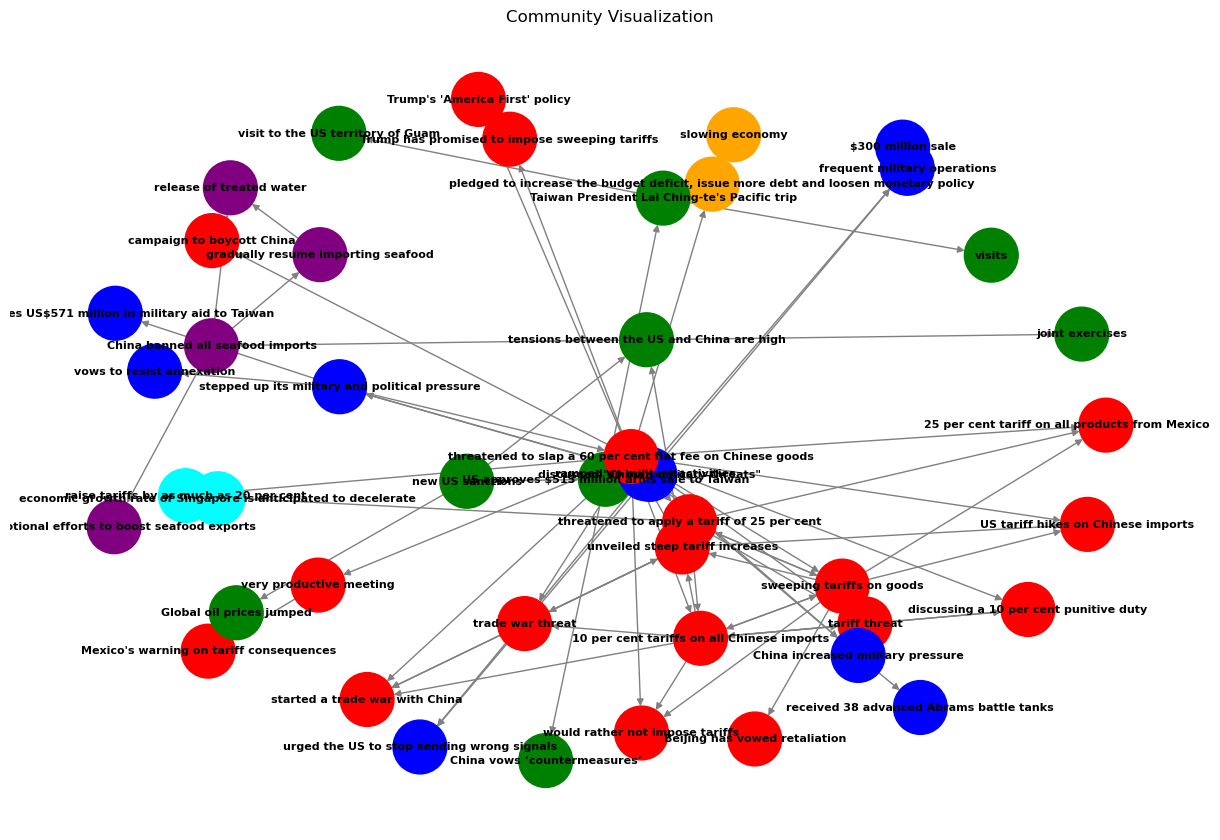

In [75]:
import matplotlib.pyplot as plt
import networkx as nx

# Assign color for each community
color_map = {}
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
for idx, community in enumerate(communities):
    for node in community:
        color_map[node] = colors[idx % len(colors)]

# Build color list for each node
node_colors = [color_map.get(node, 'gray') for node in G.nodes()]

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # or use another layout
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray',
        node_size=1500, font_size=8, font_weight='bold')
plt.title("Community Visualization")
plt.show()


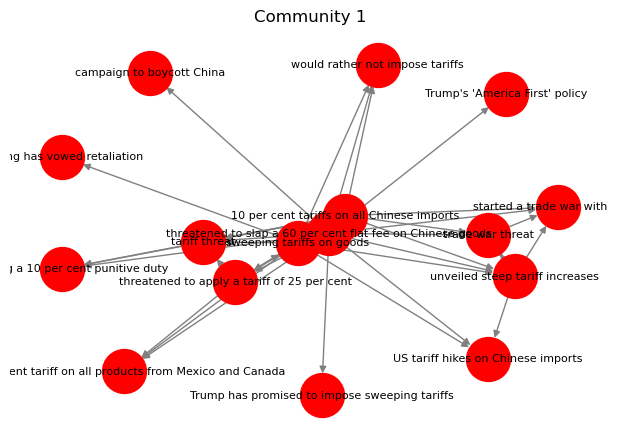

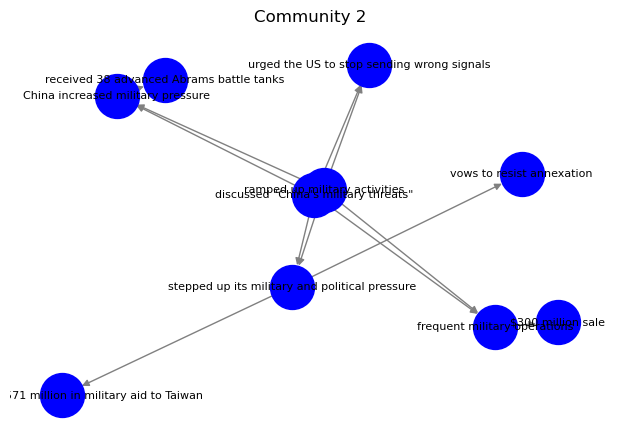

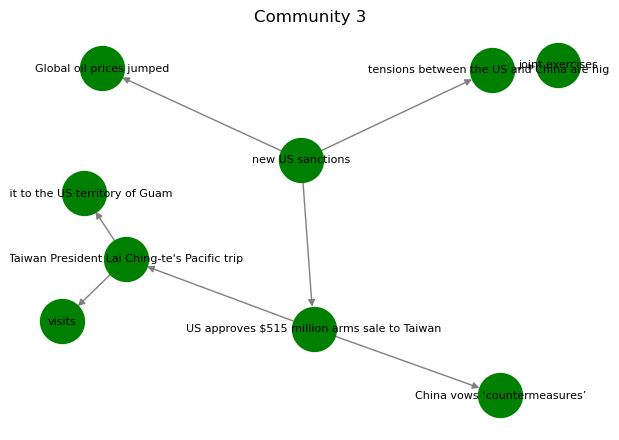

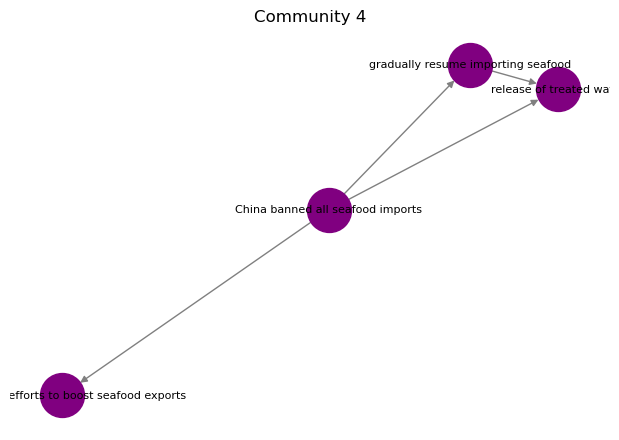

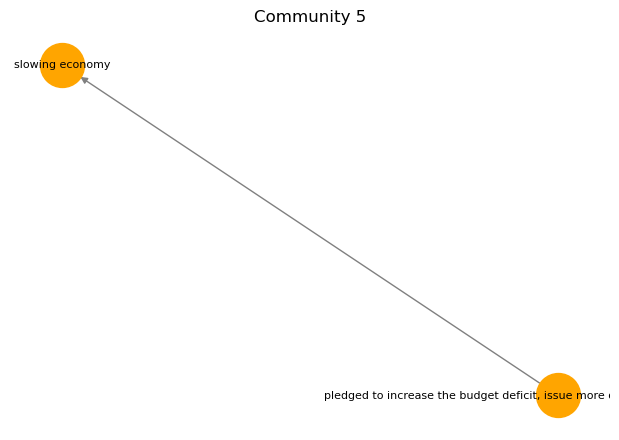

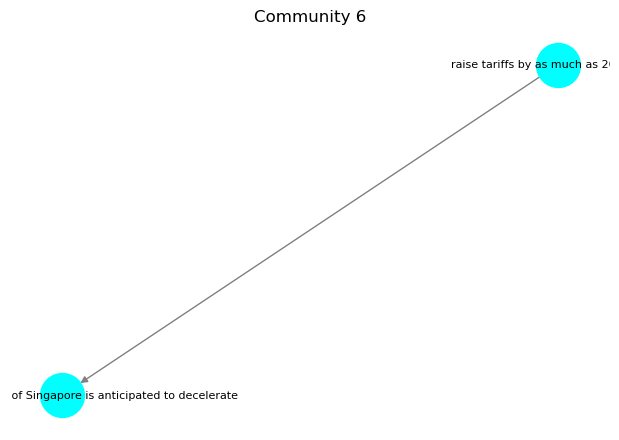

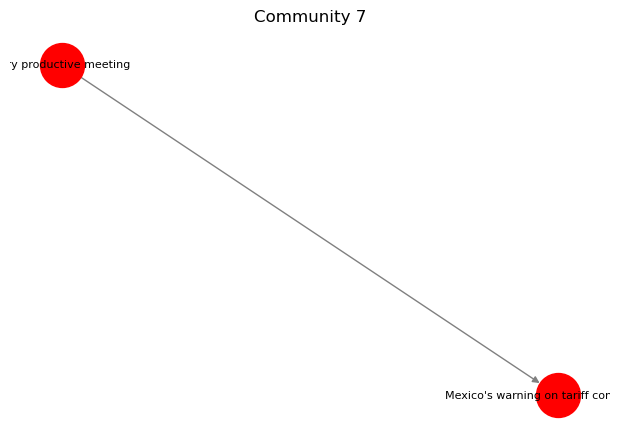

In [76]:
for idx, community in enumerate(sorted_communities):
    subG = G.subgraph(community)
    plt.figure(figsize=(6, 4))
    nx.draw(subG, with_labels=True, node_color=colors[idx % len(colors)], 
            edge_color='gray', node_size=1000, font_size=8)
    plt.title(f"Community {idx+1}")
    plt.show()


In [77]:
from pyvis.network import Network

net = Network(notebook=True, height='700px', width='100%', directed=True)
net.barnes_hut()

for idx, community in enumerate(communities):
    for node in community:
        net.add_node(node, label=node, color=colors[idx % len(colors)])

for source, target in G.edges():
    net.add_edge(source, target)

net.show("communities_interactive.html")


communities_interactive.html


In [72]:
from graphviz import Digraph

# Create a color palette for communities
community_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightsalmon']
community_map = {}

# Map each node to its community index
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Create the Graphviz Digraph
dot = Digraph(format='png')
dot.attr(rankdir='LR', size='20,10')

# Styling
node_style = {
    'shape': 'box',
    'style': 'filled',
    'fontname': 'Helvetica',
    'fontsize': '10'
}

# Track node IDs
node_ids = {}
counter = 0
edge_set = set()

# Add nodes with community-based colors
for path in extended_causal_chains:
    for i, event in enumerate(path):
        if event not in node_ids:
            node_id = f"n{counter}"
            node_ids[event] = node_id
            counter += 1

            community_idx = community_map.get(event, 0)
            color = community_colors[community_idx % len(community_colors)]
            dot.node(node_id, event, fillcolor=color, **node_style)

    # Add unique edges
    for i in range(len(path) - 1):
        source, target = path[i], path[i + 1]
        edge_key = (source, target)
        if edge_key not in edge_set:
            dot.edge(node_ids[source], node_ids[target], color='gray', penwidth='1.2')
            edge_set.add(edge_key)

# Render and save the output
output_path = "causal_flowchart_communities"
dot.render(output_path, view=False)
output_path += ".png"
output_path


'causal_flowchart_communities.png'

In [73]:
from collections import Counter

# Find causal pairs that cross between communities
cross_community_pairs = []

for path in extended_causal_chains:
    for i in range(len(path) - 1):
        source, target = path[i], path[i + 1]
        source_comm = community_map.get(source)
        target_comm = community_map.get(target)
        if source_comm is not None and target_comm is not None and source_comm != target_comm:
            cross_community_pairs.append((source, target))

# Count frequency of each cross-community pair
pair_counter = Counter(cross_community_pairs)
top_cross_pairs = pair_counter.most_common(10)
top_cross_pairs


[(('US approves $515 million arms sale to Taiwan',
   'discussed "China\'s military threats"'),
  3),
 (('stepped up its military and political pressure',
   'threatened to slap a 60 per cent flat fee on Chinese goods'),
  3)]

In [74]:
# Create a focused Graphviz diagram for only the top cross-community transitions
dot = Digraph(format='png')
dot.attr(rankdir='LR', size='12,5')

# Style setup
node_style = {
    'shape': 'box',
    'style': 'filled',
    'fontname': 'Helvetica',
    'fontsize': '10'
}

# Assign distinct colors for the communities involved in these pairs
color_map = {
    1: 'lightblue',   # Economic Measures
    2: 'lightgreen',  # Military Response
    3: 'lightcoral'   # Initial Triggers
}

used_nodes = set()

# Add nodes and edges for top cross-community transitions
for (source, target), count in top_cross_pairs:
    source_comm = community_map[source]
    target_comm = community_map[target]
    
    if source not in used_nodes:
        dot.node(source, source, fillcolor=color_map.get(source_comm, 'white'), **node_style)
        used_nodes.add(source)
    if target not in used_nodes:
        dot.node(target, target, fillcolor=color_map.get(target_comm, 'white'), **node_style)
        used_nodes.add(target)
    
    dot.edge(source, target, label=f"{count}x", color='gray', penwidth='2')

# Render output
output_path = "cross_community_flowchart"
dot.render(output_path, view=False)
output_path += ".png"
output_path


'cross_community_flowchart.png'

## Done Here

## Other insights exploration from KG

In [218]:
# Create ordered sequence of transitions
sequences = df_clean.groupby('target_date')[['source_cluster', 'target_cluster']].agg(list)
sequences['chain'] = sequences.apply(lambda row: list(zip(row.source_cluster, row.target_cluster)), axis=1)

In [219]:
sequences

,source_cluster,target_cluster,chain
target_date,,,
2016-04-07,"[territorial disputes in the South China Sea, asserting that Kuala Lumpur's oil and gas exploration infringed on China's sovereignty, China's maritime claims]","[2016 ruling of an international arbitral tribunal, 2016 ruling of an international arbitral tribunal, 2016 ruling of an international arbitral tribunal]","[(territorial disputes in the South China Sea, 2016 ruling of an international arbitral tribunal), (asserting that Kuala Lumpur's oil and gas exploration infringed on China's sovereignty, 2016 ruling of an international arbitral tribunal), (China's maritime claims, 2016 ruling of an international arbitral tribunal)]"
2023-04-07,"[1-0 win over Haiti, fusion breakthrough called ignition]","[overhauls its military strategy, fusion companies have garnered $1.4 billion in investments]","[(1-0 win over Haiti, overhauls its military strategy), (fusion breakthrough called ignition, fusion companies have garnered $1.4 billion in investments)]"
2023-06-15,"[talks to Japanese, South Korean counterparts]",[issued a joint statement to condemn],"[(talks to Japanese, South Korean counterparts, issued a joint statement to condemn)]"
2023-06-27,[Wagner mutiny],[politicising economic issues],"[(Wagner mutiny, politicising economic issues)]"
2023-07-04,[preparing an initial public offering],[talks with banks],"[(preparing an initial public offering, talks with banks)]"
...,...,...,...
2025-01-24,[fierce crackdown on illegal immigration],[deportation operation underway],"[(fierce crackdown on illegal immigration, deportation operation underway)]"
2025-02-01,"[threatened to apply a tariff of 25 per cent, surprise threat to retake control of the Panama Canal, threatened to demand, threatened to slap a 60 per cent flat fee on Chinese goods]","[sweeping tariffs on goods, refused to rule out use of military force, refused to rule out use of military force, sweeping tariffs on goods]","[(threatened to apply a tariff of 25 per cent, sweeping tariffs on goods), (surprise threat to retake control of the Panama Canal, refused to rule out use of military force), (threatened to demand, refused to rule out use of military force), (threatened to slap a 60 per cent flat fee on Chinese goods, sweeping tariffs on goods)]"
2025-02-03,"[ramped up military activities, China has ramped up military exercises, discussed ""China's military threats"", blaming Chinese pressure, sustained military pressure campaign]","[stepped up its military and political pressure, stepped up its military and political pressure, stepped up its military and political pressure, deadline to relocate, stepped up its military and political pressure]","[(ramped up military activities, stepped up its military and political pressure), (China has ramped up military exercises, stepped up its military and political pressure), (discussed ""China's military threats"", stepped up its military and political pressure), (blaming Chinese pressure, deadline to relocate), (sustained military pressure campaign, stepped up its military and political pressure)]"


In [220]:
from collections import defaultdict
transition_counts = defaultdict(lambda: defaultdict(int))

for s, t in zip(df_clean['source_cluster'], df_clean['target_cluster']):
    transition_counts[s][t] += 1

# Normalize to get probabilities
transition_prob = {
    s: {t: cnt/sum(dst.values()) for t, cnt in dst.items()}
    for s, dst in transition_counts.items()
}


In [221]:
transition_prob

{'territorial disputes in the South China Sea': {'2016 ruling of an international arbitral tribunal': 0.3333333333333333,
  'maritime run-ins': 0.3333333333333333,
  'spike in cyberattacks': 0.3333333333333333},
 "asserting that Kuala Lumpur's oil and gas exploration infringed on China's sovereignty": {'2016 ruling of an international arbitral tribunal': 1.0},
 "China's maritime claims": {'2016 ruling of an international arbitral tribunal': 0.5,
  'signed a comprehensive strategic partnership': 0.5},
 '1-0 win over Haiti': {'overhauls its military strategy': 1.0},
 'fusion breakthrough called ignition': {'fusion companies have garnered $1.4 billion in investments': 1.0},
 'talks to Japanese, South Korean counterparts': {'issued a joint statement to condemn': 1.0},
 'Wagner mutiny': {'politicising economic issues': 1.0},
 'preparing an initial public offering': {'talks with banks': 1.0},
 'ousted Mr Qin Gang': {'sacked its foreign minister': 1.0},
 'introduced an anti-espionage law': {'

In [222]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Combine both source and target cluster values
all_clusters = pd.concat([df_clean['source_cluster'], df_clean['target_cluster']]).unique()

# Fit the encoder on all possible cluster labels
le = LabelEncoder()
le.fit(all_clusters)

# Encode source and target using the same encoder
source_encoded = le.transform(df_clean['source_cluster'])[:, None]
target_encoded = le.transform(df_clean['target_cluster'])[:, None]

# Combine for modeling
encoded_pairs = np.hstack([source_encoded, target_encoded])


In [223]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.1, random_state=42)
df_clean['anomaly_score'] = clf.fit_predict(encoded_pairs)


In [224]:
# Filter only anomalies
anomalies = df_clean[df_clean['anomaly_score'] == -1][['source_cluster', 'target_cluster', 'target_date']]
display(anomalies)


,source_cluster,target_cluster,target_date
371,territorial disputes in the South China Sea,2016 ruling of an international arbitral tribunal,2016-04-07
270,asserting that Kuala Lumpur's oil and gas exploration infringed on China's sovereignty,2016 ruling of an international arbitral tribunal,2016-04-07
403,China's maritime claims,2016 ruling of an international arbitral tribunal,2016-04-07
56,frequent military operations,$300 million sale,2023-12-16
248,congratulations to president-elect Donald Trump by phone,won the election,2024-02-07
414,China has ramped up military exercises,wrapped up their largest annual military exercises,2024-05-29
425,visit to China,agree to expand military talks,2024-08-29
35,ramp up the security,fatal stabbing,2024-09-20
104,threatened to slap a 60 per cent flat fee on Chinese goods,10 per cent tariffs on all Chinese imports,2024-11-26
19,relocated from its original Russian venue,work on the temporary facility,2024-11-29


In [ ]:
# Count cross-domain transitions
cross_domain = df[df['source_cluster'] != df['target_cluster']]
transition_counts = cross_domain.groupby(['source_cluster', 'target_cluster']).size().unstack(fill_value=0)

# Plot as directed heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transition_counts, annot=True, cmap="YlOrRd", linewidths=.5, fmt="d", cbar_kws={'label': 'Transition Count'})
plt.title("Cross-Domain Event Transitions (Directed Heatmap)")
plt.ylabel("Source Cluster")
plt.xlabel("Target Cluster")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

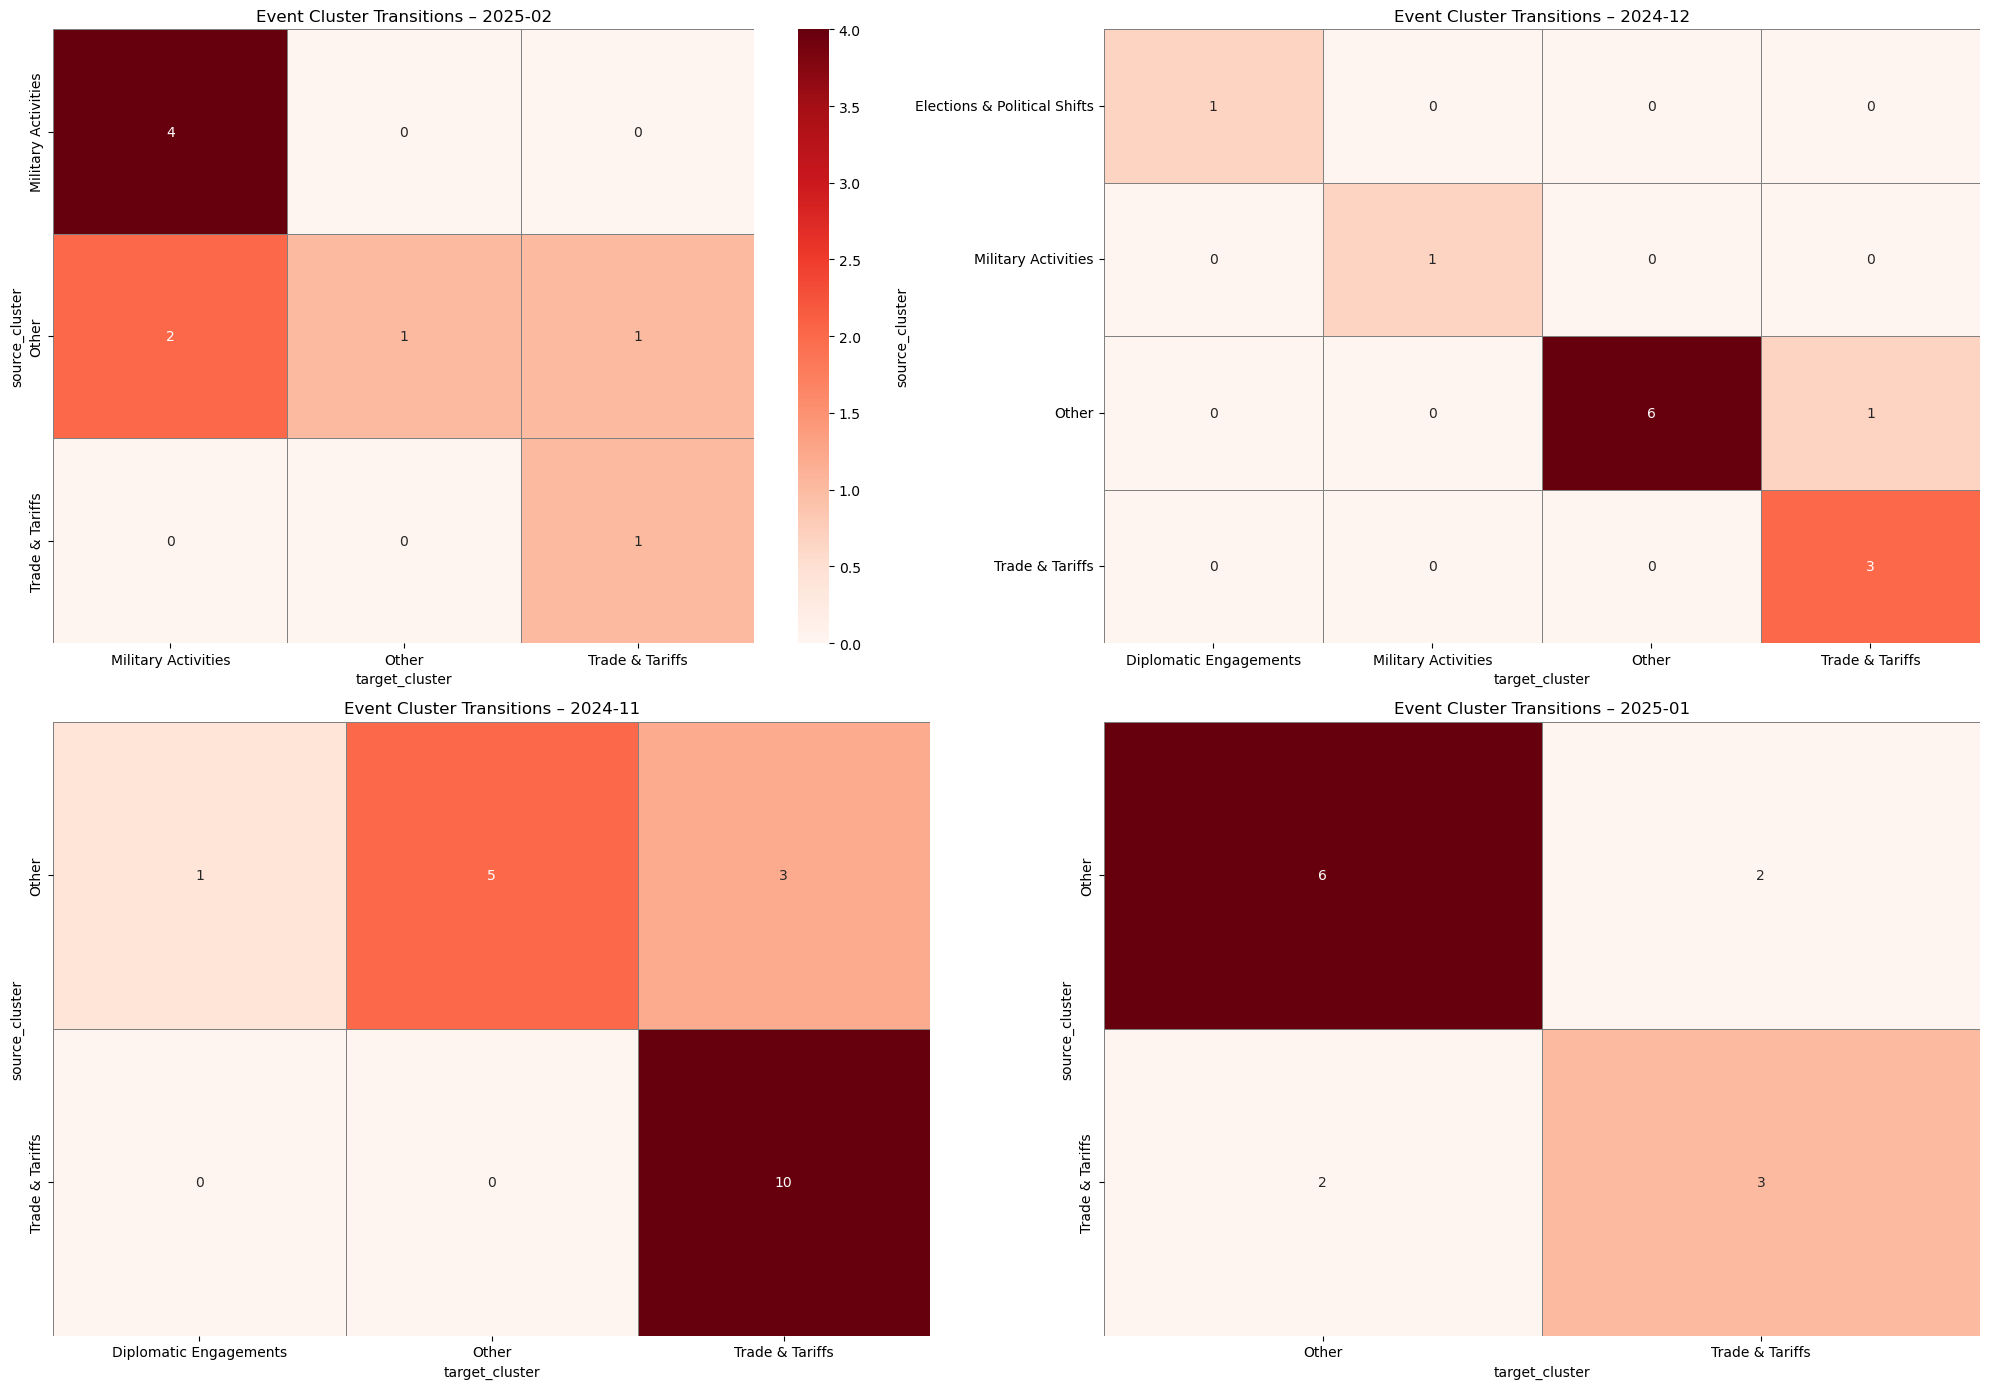

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the transition matrix with dates
transition_df = df[["source_cluster", "target_cluster", "target_date"]].dropna()

# Convert date to datetime
transition_df["target_date"] = pd.to_datetime(transition_df["target_date"], errors='coerce')
transition_df = transition_df.dropna(subset=["target_date"])

# Extract year-month for granularity
transition_df["month"] = transition_df["target_date"].dt.to_period("M").astype(str)

# Group by time and transition path
grouped = (
    transition_df.groupby(["month", "source_cluster", "target_cluster"])
    .size()
    .reset_index(name="count")
)

# Pivot to a matrix format for each top month
top_months = grouped["month"].value_counts().nlargest(4).index.tolist()
heatmaps = {}

for month in top_months:
    pivot = grouped[grouped["month"] == month].pivot_table(
        index="source_cluster", columns="target_cluster", values="count", fill_value=0
    )
    heatmaps[month] = pivot

# Plot heatmaps
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

for i, month in enumerate(top_months):
    sns.heatmap(
        heatmaps[month],
        annot=True,
        fmt="d",
        cmap="Reds",
        ax=axes[i],
        cbar=i == 0,
        linewidths=0.5,
        linecolor='gray'
    )
    axes[i].set_title(f"Event Cluster Transitions – {month}")

plt.tight_layout()
plt.show()


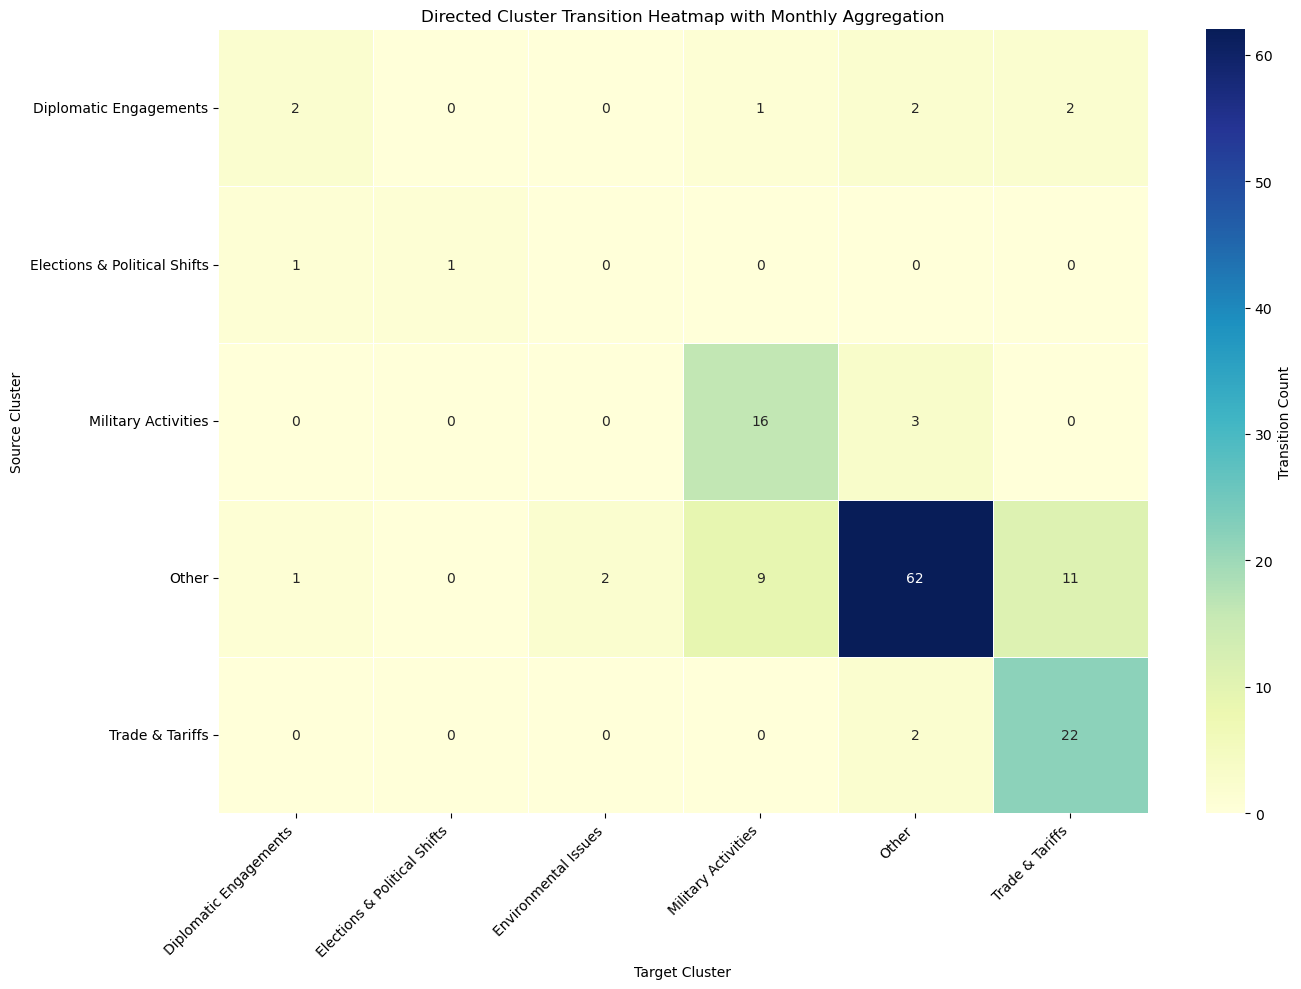

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = transition_df.copy()

# Ensure 'target_date' is datetime
df['target_date'] = pd.to_datetime(df['target_date'], errors='coerce')

# Drop rows with missing date or cluster info
df_clean = df.dropna(subset=['source_cluster', 'target_cluster', 'target_date'])

# Group by cluster transition and year-month
df_clean['year_month'] = df_clean['target_date'].dt.to_period('M')
transition_counts = df_clean.groupby(['source_cluster', 'target_cluster', 'year_month']).size().reset_index(name='count')

# Pivot to heatmap format
pivot_df = transition_counts.pivot_table(index='source_cluster', columns='target_cluster', values='count', aggfunc='sum').fillna(0)

# Plot heatmap with overlayed annotations
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Transition Count"})
plt.title("Directed Cluster Transition Heatmap with Monthly Aggregation")
plt.xlabel("Target Cluster")
plt.ylabel("Source Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [26]:
# Filter your DataFrame for directional relations only
directional_df = df[df['relation_type'].isin(['causes', 'happens_before'])].copy()

transition_counts = (
    directional_df
    .groupby(['source_cluster', 'target_cluster'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)


In [27]:
transition_counts

,source_cluster,target_cluster,count
15,Other,Other,156
21,Trade & Tariffs,Trade & Tariffs,53
17,Other,Trade & Tariffs,36
9,Military Activities,Military Activities,32
10,Military Activities,Other,19
14,Other,Military Activities,17
20,Trade & Tariffs,Other,16
11,Other,Diplomatic Engagements,9
3,Diplomatic Engagements,Other,9
0,Diplomatic Engagements,Diplomatic Engagements,7


In [35]:
transition_counts = transition_counts[(transition_counts.source_cluster!="Other") & (transition_counts.target_cluster!="Other")]

In [36]:
# Rank the target clusters for each source_cluster by frequency
top_transitions = (
    transition_counts
    .sort_values(['source_cluster', 'count'], ascending=[True, False])
    .groupby('source_cluster')
    .head(1)
    .reset_index(drop=True)
)

top_transitions


,source_cluster,target_cluster,count
0,Diplomatic Engagements,Diplomatic Engagements,7
1,Elections & Political Shifts,Diplomatic Engagements,6
2,Military Activities,Military Activities,32
3,Technology & Sanctions,Technology & Sanctions,1
4,Trade & Tariffs,Trade & Tariffs,53


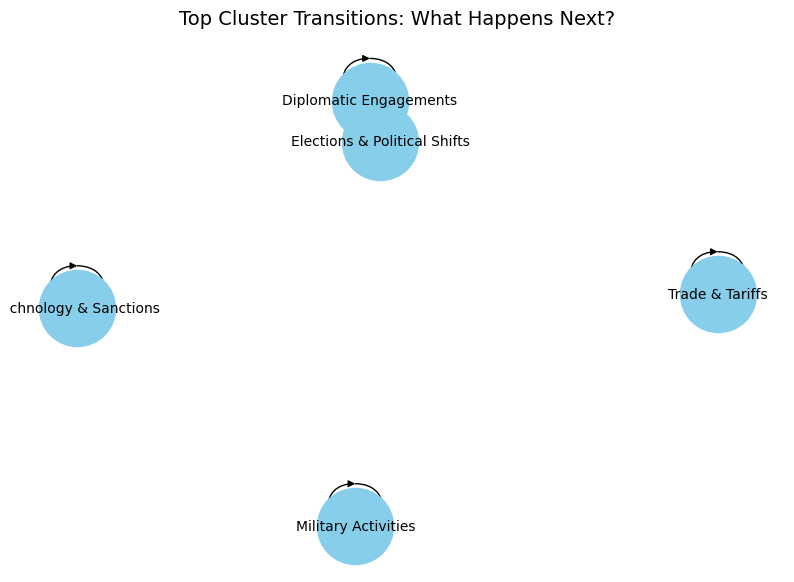

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges with weights (counts)
for _, row in top_transitions.iterrows():
    G.add_edge(row['source_cluster'], row['target_cluster'], weight=row['count'])

# Draw
fig, ax = plt.subplots(figsize=(10, 7))  # ✅ Fix: explicitly create axes
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos, ax=ax, with_labels=True,
    node_color='skyblue', node_size=3000,
    font_size=10, arrows=True
)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

plt.title("Top Cluster Transitions: What Happens Next?", fontsize=14)
plt.show()


In [41]:
from pyvis.network import Network
import pandas as pd
import networkx as nx

def create_event_influence_graph_html(df, top_n=10, output_file='event_influence_graph.html'):
    """
    Creates an interactive HTML graph showing top influential trigger events using Pyvis.

    Parameters:
    df (pd.DataFrame): DataFrame with source_trigger, target_trigger, and relation_type columns
    top_n (int): Number of top influential triggers to highlight
    output_file (str): File name for output HTML
    """
    # Step 1: Build directed NetworkX graph
    G = nx.DiGraph()
    for _, row in df.iterrows():
        src = row['source_trigger']
        tgt = row['target_trigger']
        if pd.notna(src) and pd.notna(tgt):
            G.add_edge(src, tgt, relation=row.get('relation_type', ''))

    # Step 2: Compute PageRank for influence scores
    pagerank_scores = nx.pagerank(G)
    top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = set([node for node, _ in top_nodes])

    # Step 3: Create Pyvis network
    net = Network(height="750px", width="100%", directed=True, notebook=False)
    net.force_atlas_2based()  # Better layout

    for node in G.nodes():
        net.add_node(
            node,
            label=node,
            title=f"PageRank: {pagerank_scores.get(node, 0):.4f}",
            color='red' if node in top_node_names else 'lightblue',
            size=10 + pagerank_scores.get(node, 0) * 100
        )

    for src, tgt, data in G.edges(data=True):
        net.add_edge(src, tgt, title=data.get('relation', ''))

    # Step 4: Save and show
    net.write_html(output_file)


    print(f"Event influence graph saved to: {output_file}")
    return top_nodes, G

In [42]:
top_nodes, G = create_event_influence_graph_html(df, top_n=10)
# Print the top events
for rank, (trigger, score) in enumerate(top_nodes, 1):
    print(f"{rank}. {trigger} — PageRank Score: {score:.4f}")

Event influence graph saved to: event_influence_graph.html
1. China banned all seafood imports — PageRank Score: 0.0170
2. US President Joe Biden to meet Xi Jinping — PageRank Score: 0.0140
3. release of treated water — PageRank Score: 0.0126
4. territorial disputes in the South China Sea — PageRank Score: 0.0126
5. threatened to slap a 60 per cent flat fee on Chinese goods — PageRank Score: 0.0122
6. slowing economy — PageRank Score: 0.0118
7. tensions between the US and China are high — PageRank Score: 0.0101
8. meetings with Tesla CEO Elon Musk and other US business leaders — PageRank Score: 0.0098
9. trade war threat — PageRank Score: 0.0091
10. started a trade war with China — PageRank Score: 0.0090


In [43]:
import networkx as nx

# Step 1: Compute betweenness centrality
betweenness_scores = nx.betweenness_centrality(G)

# Step 2: Sort and get top bridge nodes
sorted_betweenness = sorted(betweenness_scores.items(), key=lambda x: x[1], reverse=True)
top_bridges = sorted_betweenness[:10]

# Display
for i, (event, score) in enumerate(top_bridges, 1):
    print(f"{i}. {event} — Betweenness Centrality: {score:.4f}")


1. threatened to slap a 60 per cent flat fee on Chinese goods — Betweenness Centrality: 0.0089
2. stepped up its military and political pressure — Betweenness Centrality: 0.0048
3. tensions between the US and China are high — Betweenness Centrality: 0.0031
4. held two days of war games around the island — Betweenness Centrality: 0.0026
5. unveiled steep tariff increases — Betweenness Centrality: 0.0023
6. China banned all seafood imports — Betweenness Centrality: 0.0020
7. sweeping tariffs on goods — Betweenness Centrality: 0.0018
8. China has ramped up military exercises — Betweenness Centrality: 0.0015
9. territorial disputes in the South China Sea — Betweenness Centrality: 0.0014
10. trade war threat — Betweenness Centrality: 0.0014


In [44]:
combined_df = pd.DataFrame({
    "Node": list(G.nodes()),
    "PageRank": [pagerank_scores.get(n, 0) for n in G.nodes()],
    "Betweenness": [betweenness_scores.get(n, 0) for n in G.nodes()]
}).sort_values(["Betweenness", "PageRank"], ascending=False)

combined_df.head(10)


,Node,PageRank,Betweenness
17,threatened to slap a 60 per cent flat fee on Chinese goods,0.012157,0.008870
51,stepped up its military and political pressure,0.004068,0.004838
90,tensions between the US and China are high,0.010069,0.003143
178,held two days of war games around the island,0.005012,0.002583
150,unveiled steep tariff increases,0.006388,0.002266
69,China banned all seafood imports,0.016974,0.001968
3,sweeping tariffs on goods,0.006800,0.001819
109,China has ramped up military exercises,0.004125,0.001456
68,territorial disputes in the South China Sea,0.012558,0.001449
148,trade war threat,0.009104,0.001448


In [47]:
df

,source_cluster_id,target_cluster_id,relation_type,description,source_trigger,source_summary,target_trigger,target_summary,confidence_score,explanation,...,source_location,target_location,source_lat,source_lon,target_lat,target_lon,source_date,target_date,source_cluster,target_cluster
0,42,44,causes,The plan to merge USAID into the State Department is a direct response to President Trump's executive order pausing most foreign aid.,merging the US international aid agency (USAID) into the State Department,The Trump administration considers integrating USAID into the State Department to better align with 'America First' policy objectives.,90-day pause in most of foreign aid,"President Trump issued an executive order pausing most foreign aid, citing misalignment with American interests.",NaN,NaN,...,NaN,United States,NaN,NaN,39.783730,-100.445882,None,2025-01-20,Other,Other
1,447,179,causes,The retaliation is a direct response to the US tariffs.,Rubio to make debut in Panama,Marco Rubio embarked on his first international trip as US Secretary of State to Panama amidst escalating tensions over President Donald Trump's remarks regarding the Panama Canal.,sweeping tariffs on goods,Canada and Mexico have announced that they will retaliate against US tariffs imposed by President Donald Trump.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,Other,Trade & Tariffs
2,240,239,causes,South Africa's deadline is a response to pressure from China,blaming Chinese pressure,"Taiwan has accused China of exerting pressure on South Africa, causing the demand for the embassy's relocation.",deadline to relocate,The South African government set a deadline for Taiwan to relocate its de facto embassy from Pretoria by the end of March 2025 due to Chinese pressure.,NaN,NaN,...,NaN,"Pretoria, South Africa",NaN,NaN,-25.745928,28.187910,None,2025-02-03,Other,Other
3,3973,447,causes,Rubio's trip is in response to Trump's statements about the Panama Canal,surprise threat to retake control of the Panama Canal,"Donald Trump threatens to retake control of the Panama Canal, challenging the current Panamanian management and warning against Chinese influence.",Rubio to make debut in Panama,Marco Rubio embarked on his first international trip as US Secretary of State to Panama amidst escalating tensions over President Donald Trump's remarks regarding the Panama Canal.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,Other,Other
5,2570,2798,causes,The new US sanctions led to an increase in oil prices.,new US sanctions,The United States imposed sweeping sanctions on Russia's oil industry to target Russia's oil and gas revenues aimed at influencing peace negotiations in Ukraine.,Global oil prices jumped,"Global oil prices surged by more than 3% after news of the U.S. sanctions on Russian oil spread, reflecting market concerns.",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,Technology & Sanctions,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,33592,33682,happens_before,NaN,equated his Chinese counterpart Xi Jinping with 'dictators',"US President Joe Biden compared China's President Xi Jinping to dictators at a Democratic donor reception, likely causing diplomatic tension.",tensions between the US and China are high,Rivalry between the US and China has increased global geopolitical tensions and fragmented international relations.,0.786458,Event 'equated his Chinese counterpart Xi Jinping with 'dictators'' happens_before Event 'growing rivalry between the US and China' via COMET: 'US-China relations are strained',...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,Other,Other
437,33832,272,happens_before,NaN,imposing a sweeping ban on semiconductor exports,"Biden took strong measures against China, including a ban on semiconductor exports as part of overarching strategies addressing US-China competition.",threatened to slap a 60 per cent flat fee on Chinese goods,"President-elect Trump threatened to impose a substantial tariff on Chinese goods

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data.csv")

In [3]:
from pyvis.network import Network
import networkx as nx
G = nx.DiGraph()
for _, row in df.iterrows():
    src = row['source_trigger']
    tgt = row['target_trigger']
    relation_type = row["relation_type"]
    source_date = row["source_date"]
    target_date = row["target_date"]
    if pd.notna(src) and pd.notna(tgt):
        G.add_edge(
                src, 
                tgt,
                relation=relation_type,
                source_date=source_date,
                target_date=target_date
            )



In [4]:
patterns = []
for node in G.nodes:
    for neighbor1 in G.successors(node):
        rel1 = G[node][neighbor1].get('relation')
        for neighbor2 in G.successors(neighbor1):
            rel2 = G[neighbor1][neighbor2].get('relation')
            patterns.append(((node, rel1, neighbor1, rel2, neighbor2)))


In [5]:
patterns

[('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'happens_before',
  'threatened to slap a 60 per cent flat fee on Chinese goods'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'happens_before',
  '10 per cent tariffs on all Chinese imports'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'happens_before',
  'tariff threat'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'happens_before',
  'threatened to apply a tariff of 25 per cent'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'happens_before',
  '25 per cent tariff on all products from Mexico and Canada'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'causes',
  'US tariff hikes on Chinese imports'),
 ('Rubio to make debut in Panama',
  'causes',
  'sweeping tariffs on goods',
  'causes',
  'Beijing has vowed retaliation'),
 ('Ru

In [6]:
G_undirected = G.to_undirected()


In [7]:
from node2vec import Node2Vec

# Initialize Node2Vec
node2vec = Node2Vec(G_undirected, dimensions=64, walk_length=10, num_walks=100, workers=2)

# Fit the model
model = node2vec.fit(window=5, min_count=1)

# Get embedding for a node (event)
embedding = model.wv['China banned all seafood imports']


Computing transition probabilities:   0%|          | 0/272 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 201.59it/s]


In [8]:
embedding

array([ 0.51885986, -0.8300245 , -0.1281337 ,  0.38682783, -0.15597925,
       -0.4483125 ,  0.68006176,  0.16906452, -0.40590456,  0.0609749 ,
        0.21669205,  0.04017378, -0.57916135,  0.07248409, -0.09144467,
        0.8417146 , -0.23179291, -0.21159048, -0.27199045,  0.14353472,
        0.36035338,  0.7196181 ,  0.6128179 , -0.702389  ,  0.41570503,
        0.89470345,  0.28252548,  0.5922482 ,  0.0576598 , -0.48869684,
        0.42767277,  0.28329757,  0.09466278, -0.40131393, -0.28989938,
       -0.4912735 ,  0.5498542 ,  0.02179333, -0.2861931 , -0.5402472 ,
        0.1133666 , -0.0508148 ,  1.0706555 , -0.1383595 ,  0.27531818,
        0.26798937,  0.5234116 , -1.0055889 , -0.09383542, -0.5902471 ,
       -0.18299332,  0.25762635,  0.41210595,  0.07132711,  0.04842913,
        0.32139573,  0.5152874 , -0.12494607,  0.39920232, -0.25040427,
       -0.16557145,  0.37599957, -0.26072764,  0.50886095], dtype=float32)

In [9]:
from node2vec import Node2Vec
import networkx as nx

# Ensure graph is undirected for Node2Vec (or directed if supported in your library)
G_undirected = G.to_undirected()

# Run Node2Vec
node2vec = Node2Vec(G_undirected, dimensions=64, walk_length=20, num_walks=100, workers=2)
model = node2vec.fit(window=10, min_count=1)


Computing transition probabilities:   0%|          | 0/272 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 101.07it/s]


In [10]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Build node and embedding arrays
nodes = list(G_undirected.nodes())
embeddings = np.array([model.wv[node] for node in nodes])

# UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(embeddings)


2025-04-07 15:03:44.402784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 15:03:45.016430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


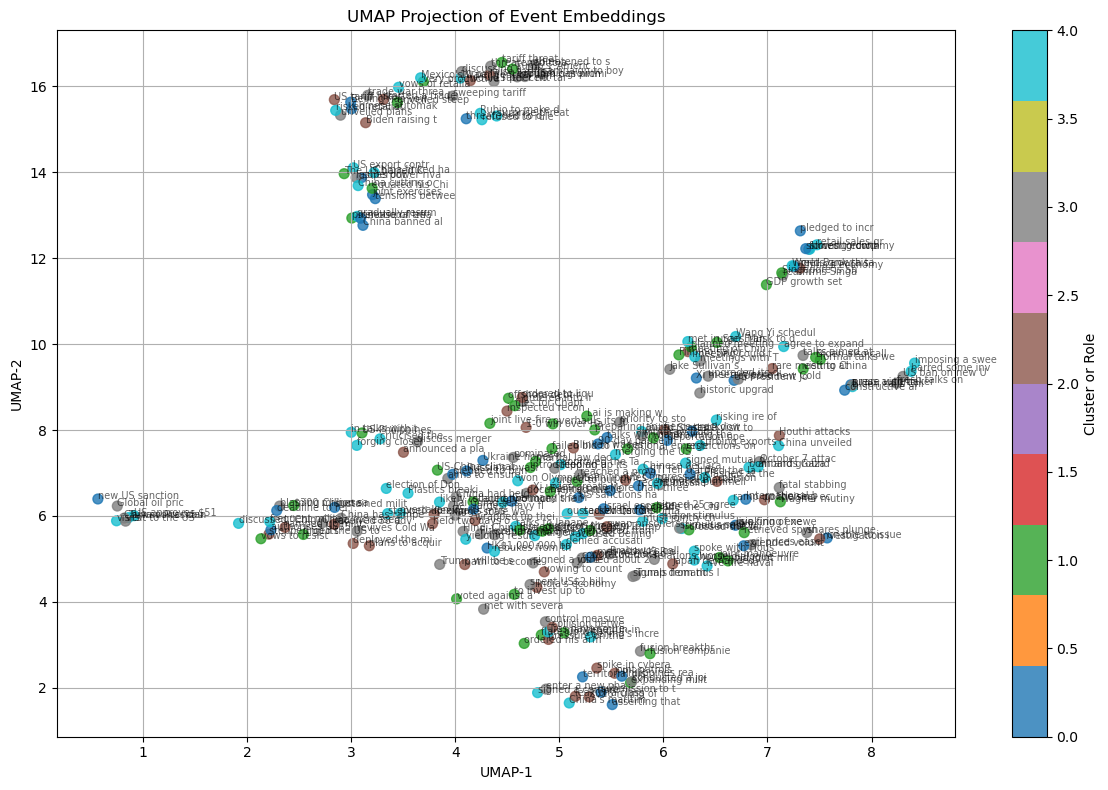

In [11]:
# Optional: create dummy cluster labels
import random
cluster_labels = [G.nodes[node].get("cluster_id", random.randint(0, 4)) for node in nodes]

# Plot UMAP with cluster coloring
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.8)

# Optional: add labels
for i, node in enumerate(nodes):
    plt.text(X_umap[i, 0], X_umap[i, 1], node[:15], fontsize=7, alpha=0.6)

plt.colorbar(scatter, label="Cluster or Role")
plt.title("UMAP Projection of Event Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.ensemble import IsolationForest

# Prepare matrix of all embeddings
X_all = np.array([model.wv[node] for node in model.wv.index_to_key])

# Fit anomaly detector
detector = IsolationForest(contamination=0.1, random_state=42)
scores = detector.fit_predict(X_all)

# Find anomalies
anomalous_nodes = [node for i, node in enumerate(model.wv.index_to_key) if scores[i] == -1]
print("Anomalous events:", anomalous_nodes)


Anomalous events: ['extended voluntary supply cuts', 'talks with banks', 'prepared to meet Russian President Vladimir Putin', 'yielding results', 'oil prices eased', 'work on the temporary facility', 'swap prisoners', 'friendly Trump call', 'relocated from its original Russian venue', 'announced a plan to cut 9,000 jobs', 'Xi urges greater innovation', 'nominated', 'Houthi attacks on shipping in the Red Sea', 'voted against a US$95 billion military aid package for Ukraine', 'met with several US company representatives', 'overhauls its military strategy', 'clashed at the Second Thomas Shoal', 'crossed the Taiwan Strait median line', 'charged with acting as an unregistered agent', 'arrested in Cyprus', 'issued arrest warrants', 'fusion companies have garnered $1.4 billion in investments', 'Israel escalated its bombardment of Gaza', 'Hindi-Chini bye, bye', 'Fukushima water discharge plan', 'Trump will be sworn in', 'introduced an anti-espionage law', 'oath to become the United States’ 47t

In [13]:
anomalous_nodes

['extended voluntary supply cuts',
 'talks with banks',
 'prepared to meet Russian President Vladimir Putin',
 'yielding results',
 'oil prices eased',
 'work on the temporary facility',
 'swap prisoners',
 'friendly Trump call',
 'relocated from its original Russian venue',
 'announced a plan to cut 9,000 jobs',
 'Xi urges greater innovation',
 'nominated',
 'Houthi attacks on shipping in the Red Sea',
 'voted against a US$95 billion military aid package for Ukraine',
 'met with several US company representatives',
 'overhauls its military strategy',
 'clashed at the Second Thomas Shoal',
 'crossed the Taiwan Strait median line',
 'charged with acting as an unregistered agent',
 'arrested in Cyprus',
 'issued arrest warrants',
 'fusion companies have garnered $1.4 billion in investments',
 'Israel escalated its bombardment of Gaza',
 'Hindi-Chini bye, bye',
 'Fukushima water discharge plan',
 'Trump will be sworn in',
 'introduced an anti-espionage law',
 'oath to become the United St

In [15]:
from sklearn.cluster import KMeans
import numpy as np

# Build embedding matrix
nodes = list(model.wv.index_to_key)
X = np.array([model.wv[n] for n in nodes])

# Run KMeans (try other methods too)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)


/home/user/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
cluster_labels

array([0, 0, 0, 3, 4, 4, 0, 4, 4, 0, 3, 4, 0, 3, 0, 3, 3, 0, 1, 3, 0, 4,
       4, 4, 3, 0, 0, 3, 0, 3, 1, 4, 3, 2, 1, 1, 1, 2, 1, 0, 0, 4, 0, 0,
       3, 0, 1, 1, 3, 1, 0, 3, 1, 1, 0, 0, 0, 3, 0, 0, 4, 0, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 1, 1, 0, 1, 1, 3, 1, 1, 0, 3, 1, 0, 0, 3, 0, 0, 0, 4,
       3, 0, 2, 0, 1, 0, 4, 1, 1, 0, 1, 4, 4, 4, 1, 1, 3, 0, 1, 0, 0, 4,
       1, 0, 2, 0, 4, 0, 0, 1, 3, 4, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 3,
       1, 0, 0, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 3,
       3, 4, 4, 0, 3, 4, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3], dtype=int32)

In [17]:
from sklearn.ensemble import IsolationForest

detector = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = detector.fit_predict(X)  # -1 = anomaly, 1 = normal

# Get anomalous events
anomalies = [nodes[i] for i, label in enumerate(anomaly_labels) if label == -1]
print("🔍 Unusual events:", anomalies[:10])


🔍 Unusual events: ['extended voluntary supply cuts', 'prepared to meet Russian President Vladimir Putin', 'oil prices eased', 'friendly Trump call', 'relocated from its original Russian venue', 'Xi urges greater innovation', 'met with several US company representatives', 'crossed the Taiwan Strait median line', 'charged with acting as an unregistered agent', 'arrested in Cyprus']


In [19]:
# Extract nodes and embedding vectors
nodes = list(model.wv.index_to_key)
X = np.array([model.wv[n] for n in nodes])


In [38]:
from sklearn.ensemble import IsolationForest

# Fit anomaly detector
iso = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal


In [39]:
import umap
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(X)


/home/user/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_240632/386173623.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/home/user/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


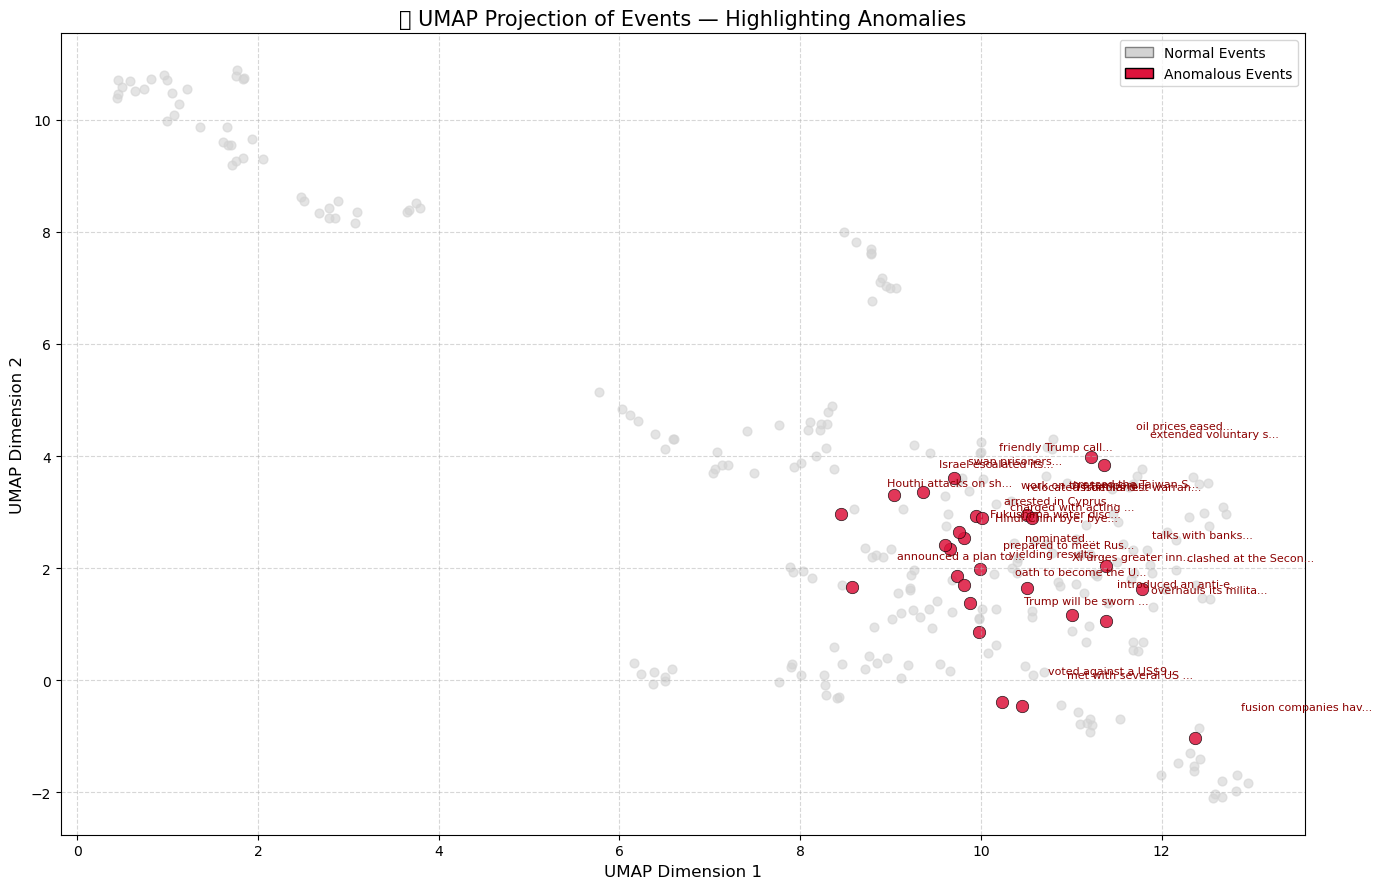

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(14, 9))

# Plot normal points
normal_x = X_umap[anomaly_labels == 1, 0]
normal_y = X_umap[anomaly_labels == 1, 1]
plt.scatter(normal_x, normal_y, color="lightgray", s=40, alpha=0.6, label="Normal Events")

# Plot anomalous points
anomaly_x = X_umap[anomaly_labels == -1, 0]
anomaly_y = X_umap[anomaly_labels == -1, 1]
plt.scatter(anomaly_x, anomaly_y, color="crimson", s=80, alpha=0.85, label="Anomalous Events", edgecolor='black', linewidth=0.5)

# Annotate anomalies with clearer labels
for i, label in enumerate(anomaly_labels):
    if label == -1:
        plt.text(X_umap[i, 0]+0.5, X_umap[i, 1]+0.5, nodes[i][:20] + "...", fontsize=8, color="darkred")

# Title and axes
plt.title("🔍 UMAP Projection of Events — Highlighting Anomalies", fontsize=15)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Custom legend
legend_elements = [
    Patch(facecolor='lightgray', edgecolor='gray', label='Normal Events'),
    Patch(facecolor='crimson', edgecolor='black', label='Anomalous Events')
]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()


In [42]:
anomalies = [nodes[i] for i, val in enumerate(anomaly_labels) if val == -1]
print("Top Anomalous Events:")
for a in anomalies:
    print("⚠️", a)

Top Anomalous Events:
⚠️ extended voluntary supply cuts
⚠️ talks with banks
⚠️ prepared to meet Russian President Vladimir Putin
⚠️ yielding results
⚠️ oil prices eased
⚠️ work on the temporary facility
⚠️ swap prisoners
⚠️ friendly Trump call
⚠️ relocated from its original Russian venue
⚠️ announced a plan to cut 9,000 jobs
⚠️ Xi urges greater innovation
⚠️ nominated
⚠️ Houthi attacks on shipping in the Red Sea
⚠️ voted against a US$95 billion military aid package for Ukraine
⚠️ met with several US company representatives
⚠️ overhauls its military strategy
⚠️ clashed at the Second Thomas Shoal
⚠️ crossed the Taiwan Strait median line
⚠️ charged with acting as an unregistered agent
⚠️ arrested in Cyprus
⚠️ issued arrest warrants
⚠️ fusion companies have garnered $1.4 billion in investments
⚠️ Israel escalated its bombardment of Gaza
⚠️ Hindi-Chini bye, bye
⚠️ Fukushima water discharge plan
⚠️ Trump will be sworn in
⚠️ introduced an anti-espionage law
⚠️ oath to become the United States

In [43]:
# Count how many times each trigger appears in source or target
from collections import Counter

trigger_freq = Counter(df['source_trigger'].tolist() + df['target_trigger'].tolist())

# Example: frequency of anomaly events
for event in anomalies:
    print(f"{event}: {trigger_freq.get(event, 0)} occurrence(s)")


extended voluntary supply cuts: 1 occurrence(s)
talks with banks: 1 occurrence(s)
prepared to meet Russian President Vladimir Putin: 1 occurrence(s)
yielding results: 1 occurrence(s)
oil prices eased: 1 occurrence(s)
work on the temporary facility: 1 occurrence(s)
swap prisoners: 1 occurrence(s)
friendly Trump call: 1 occurrence(s)
relocated from its original Russian venue: 1 occurrence(s)
announced a plan to cut 9,000 jobs: 1 occurrence(s)
Xi urges greater innovation: 1 occurrence(s)
nominated: 1 occurrence(s)
Houthi attacks on shipping in the Red Sea: 1 occurrence(s)
voted against a US$95 billion military aid package for Ukraine: 1 occurrence(s)
met with several US company representatives: 1 occurrence(s)
overhauls its military strategy: 1 occurrence(s)
clashed at the Second Thomas Shoal: 1 occurrence(s)
crossed the Taiwan Strait median line: 1 occurrence(s)
charged with acting as an unregistered agent: 1 occurrence(s)
arrested in Cyprus: 1 occurrence(s)
issued arrest warrants: 1 occ

In [44]:
# Degree centrality (how many edges they have)
centrality = nx.degree_centrality(G)

# PageRank (for influence context)
pagerank = nx.pagerank(G)

for event in anomalies:
    print(f"{event}\n- Degree: {centrality.get(event, 0):.3f}, PageRank: {pagerank.get(event, 0):.4f}\n")


extended voluntary supply cuts
- Degree: 0.004, PageRank: 0.0037

talks with banks
- Degree: 0.004, PageRank: 0.0037

prepared to meet Russian President Vladimir Putin
- Degree: 0.004, PageRank: 0.0037

yielding results
- Degree: 0.004, PageRank: 0.0020

oil prices eased
- Degree: 0.004, PageRank: 0.0020

work on the temporary facility
- Degree: 0.004, PageRank: 0.0037

swap prisoners
- Degree: 0.004, PageRank: 0.0037

friendly Trump call
- Degree: 0.004, PageRank: 0.0020

relocated from its original Russian venue
- Degree: 0.004, PageRank: 0.0020

announced a plan to cut 9,000 jobs
- Degree: 0.004, PageRank: 0.0037

Xi urges greater innovation
- Degree: 0.004, PageRank: 0.0037

nominated
- Degree: 0.004, PageRank: 0.0037

Houthi attacks on shipping in the Red Sea
- Degree: 0.004, PageRank: 0.0037

voted against a US$95 billion military aid package for Ukraine
- Degree: 0.004, PageRank: 0.0020

met with several US company representatives
- Degree: 0.004, PageRank: 0.0037

overhauls its

In [46]:
df[df.confidence_score>0.7]

,source_cluster_id,target_cluster_id,relation_type,description,source_trigger,source_summary,target_trigger,target_summary,confidence_score,explanation,...,source_location,target_location,source_lat,source_lon,target_lat,target_lon,source_date,target_date,source_cluster,target_cluster
80,85,272,happens_before,NaN,sweeping tariffs on goods,US President Donald Trump ordered sweeping tar...,threatened to slap a 60 per cent flat fee on C...,President-elect Trump threatened to impose a s...,0.740394,Event 'sweeping tariffs on goods' happens_befo...,...,United States,NaN,39.783730,-100.445882,NaN,NaN,2025-02-01,NaN,Trade & Tariffs,Other
81,85,5089,happens_before,NaN,sweeping tariffs on goods,US President Donald Trump ordered sweeping tar...,10 per cent tariffs on all Chinese imports,President-elect Donald Trump announced plans t...,0.720066,Event 'sweeping tariffs on goods' happens_befo...,...,United States,United States,39.783730,-100.445882,39.783730,-100.445882,2025-02-01,2024-11-26,Trade & Tariffs,Trade & Tariffs
82,85,5442,happens_before,NaN,sweeping tariffs on goods,US President Donald Trump ordered sweeping tar...,tariff threat,US President-elect Donald Trump threatened to ...,0.750436,Event 'sweeping tariffs on goods' happens_befo...,...,United States,United States,39.783730,-100.445882,39.783730,-100.445882,2025-02-01,2024-12-01,Trade & Tariffs,Trade & Tariffs
83,85,6083,happens_before,NaN,sweeping tariffs on goods,US President Donald Trump ordered sweeping tar...,threatened to apply a tariff of 25 per cent,President-elect Donald Trump threatened to imp...,0.720860,Event 'sweeping tariffs on goods' happens_befo...,...,United States,United States,39.783730,-100.445882,39.783730,-100.445882,2025-02-01,2024-11-30,Trade & Tariffs,Trade & Tariffs
84,85,6406,happens_before,NaN,sweeping tariffs on goods,US President Donald Trump ordered sweeping tar...,10 per cent tariffs on all Chinese imports,Donald Trump announced plans to impose a 10% t...,0.715570,Event 'sweeping tariffs on goods' happens_befo...,...,United States,NaN,39.783730,-100.445882,NaN,NaN,2025-02-01,NaN,Trade & Tariffs,Trade & Tariffs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,33592,33682,happens_before,NaN,equated his Chinese counterpart Xi Jinping wit...,US President Joe Biden compared China's Presid...,tensions between the US and China are high,Rivalry between the US and China has increased...,0.786458,Event 'equated his Chinese counterpart Xi Jinp...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other
400,33832,272,happens_before,NaN,imposing a sweeping ban on semiconductor exports,"Biden took strong measures against China, incl...",threatened to slap a 60 per cent flat fee on C...,President-elect Trump threatened to impose a s...,0.705279,Event 'imposing a sweeping ban on semiconducto...,...,"United States, China",NaN,30.047992,-94.335743,NaN,NaN,NaN,NaN,Trade & Tariffs,Other
401,33954,25670,happens_before,NaN,a rare visit to Beijing by US Secretary of Sta...,US Secretary of State Antony Blinken visited B...,US President Joe Biden to meet Xi Jinping,US and Chinese leaders are set to meet to addr...,0.721065,Event 'a rare visit to Beijing by US Secretary...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Diplomatic Engagements,Elections & Political Shifts
402,33954,26190,happens_before,NaN,a rare visit to Beijing by US Secretary of Sta...,US Secretary of State Antony Blinken visited B...,constructive arms control talks,The United States and China held constructive ...,0.767622,Event 'a rare visit to Beijing by US Secretary...,...,NaN,"Washington, D.C.",NaN,NaN,38.895037,-77.036543,NaN,2023-11-06,Diplomatic Engagements,Other


In [48]:
import networkx as nx

G = nx.DiGraph()
for _, row in df.iterrows():
    src = row['source_trigger']
    tgt = row['target_trigger']
    G.add_edge(src, tgt, relation=row['relation_type'])


In [53]:
# Find all simple cycles (can be long-running)
cycles = list(nx.simple_cycles(G))

# Filter: keep only cycles longer than 1 node
feedback_loops = [cycle for cycle in cycles if len(cycle) > 1]

# Print examples
for i, loop in enumerate(feedback_loops[:5], 1):
    print(f"🔁 Loop {i}: {' → '.join(loop)}")


🔁 Loop 1: meets growth target → GDP growth set to hit target → China's economy grew 5.2 per cent in 2023
🔁 Loop 2: meets growth target → GDP growth set to hit target
🔁 Loop 3: meets growth target → China's economy grew 5.2 per cent in 2023 → GDP growth set to hit target
🔁 Loop 4: meets growth target → China's economy grew 5.2 per cent in 2023
🔁 Loop 5: China's economy grew 5.2 per cent in 2023 → GDP growth set to hit target


In [50]:
causal_edges = df[df['relation_type'] == 'causes']
G_causal = nx.DiGraph()
for _, row in causal_edges.iterrows():
    G_causal.add_edge(row['source_trigger'], row['target_trigger'])

feedback_causal_loops = list(nx.simple_cycles(G_causal))


In [51]:
feedback_causal_loops

[]

In [52]:
df["relation_type"].value_counts()

happens_before    296
causes             92
related_to         16
Name: relation_type, dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   source_cluster_id         404 non-null    int64  
 1   target_cluster_id         404 non-null    int64  
 2   relation_type             404 non-null    object 
 3   description               80 non-null     object 
 4   source_trigger            404 non-null    object 
 5   source_summary            404 non-null    object 
 6   target_trigger            404 non-null    object 
 7   target_summary            404 non-null    object 
 8   confidence_score          324 non-null    float64
 9   explanation               324 non-null    object 
 10  evidence_type             324 non-null    object 
 11  source_trigger_arguments  151 non-null    object 
 12  target_trigger_arguments  187 non-null    object 
 13  source_trigger_time       149 non-null    object 
 14  target_tri

In [57]:
df.source_cluster.value_counts()

Other                           235
Trade & Tariffs                  70
Military Activities              52
Diplomatic Engagements           25
Elections & Political Shifts     14
Technology & Sanctions            6
Environmental Issues              2
Name: source_cluster, dtype: int64

In [58]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # or another multilingual model
event_texts = list(set(df['source_trigger']) | set(df['target_trigger']))
embeddings = model.encode(event_texts, show_progress_bar=True)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [59]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, linkage='average', affinity='cosine')
labels = clustering.fit_predict(embeddings)


/home/user/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [60]:
import numpy as np
from collections import defaultdict

clustered = defaultdict(list)
for idx, label in enumerate(labels):
    clustered[label].append(event_texts[idx])

# Label clusters with top keywords or first few items
cluster_labels = {label: clustered[label][0] for label in clustered}


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(events, top_k=3):
    vec = TfidfVectorizer(stop_words='english')
    X = vec.fit_transform(events)
    keywords = np.array(vec.get_feature_names_out())[X.sum(axis=0).A1.argsort()[-top_k:]]
    return ", ".join(keywords[::-1])


In [62]:
event_to_cluster = dict(zip(event_texts, labels))
event_to_label = {event: f"Cluster {event_to_cluster[event]}: {cluster_labels[event_to_cluster[event]]}" for event in event_texts}

df['source_narrative'] = df['source_trigger'].map(event_to_label)
df['target_narrative'] = df['target_trigger'].map(event_to_label)


In [65]:
event_to_label

{'urged to put the interests of the people first and cease fire': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'approved the Taiwan Policy Act': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'Beijing has vowed retaliation': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'Philippines reaches a deal with China': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'issued a joint statement to condemn': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'sweeping tariffs on goods': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'recent missile attack on military targets near Tel Aviv': 'Cluster 0: urged to put the interests of the people first and cease fire',
 'discussed "China\'s military threats"': 'Cluster 0: urged to put the interests of the people first and cease fire',
 "Biden calls China a 'ticking time bomb'":

In [64]:
df[["source_narrative","target_narrative"]]

,source_narrative,target_narrative
0,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
1,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
2,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
3,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
4,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
...,...,...
399,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
400,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
401,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...
402,Cluster 0: urged to put the interests of the p...,Cluster 0: urged to put the interests of the p...


In [68]:
df["source_cluster"].value_counts()

Other                           235
Trade & Tariffs                  70
Military Activities              52
Diplomatic Engagements           25
Elections & Political Shifts     14
Technology & Sanctions            6
Environmental Issues              2
Name: source_cluster, dtype: int64

In [70]:
df["target_cluster"].value_counts()

Other                           223
Trade & Tariffs                  92
Military Activities              51
Diplomatic Engagements           23
Elections & Political Shifts     10
Environmental Issues              3
Technology & Sanctions            2
Name: target_cluster, dtype: int64

In [72]:
transitions

defaultdict(list,
            {'Other': ['Other',
              'Trade & Tariffs',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Military Activities',
              'Diplomatic Engagements',
              'Elections & Political Shifts',
              'Other',
              'Other',
              'Other',
              'Other',
              'Military Activities',
              'Military Activities',
              'Other',
              'Other',
              'Other',
              'Other',
              'Trade & Tariffs',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other

In [77]:
aa = df[(df.source_cluster!="Other") & (df.target_cluster!="Other")]

In [83]:
import pandas as pd
from collections import defaultdict

# Assume df contains 'source_cluster' and 'target_cluster'
transitions = defaultdict(list)
for _, row in df.iterrows():
    transitions[row['source_cluster']].append(row['target_cluster'])

# Count and normalize transitions
next_probs = {}
for src, targets in transitions.items():
    counts = pd.Series(targets).value_counts(normalize=True)
    next_probs[src] = counts.to_dict()

# Predict for a current cluster
current = 'Trade & Tariffs'
probs = next_probs.get(current, {})

if not probs:
    print(f"No transitions found for '{current}'")
else:
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    
    # Self-loop (if exists)
    self_loop = next((target for target in sorted_probs if target[0] == current), None)
    
    # First non-self loop transition
    next_event = next((target for target in sorted_probs if target[0] != current), None)
    
    print(f"🔁 From '{current}' →")
    if self_loop:
        print(f"  - Most likely to stay within the same narrative (self-loop): {self_loop[1]:.2f}")
    if next_event:
        print(f"  - Next most likely different narrative: '{next_event[0]}' (Prob: {next_event[1]:.2f})")


🔁 From 'Trade & Tariffs' →
  - Most likely to stay within the same narrative (self-loop): 0.76
  - Next most likely different narrative: 'Other' (Prob: 0.24)


In [87]:
import pandas as pd
from collections import defaultdict

# Simulate the 'aa' DataFrame structure for demonstration
# Replace this with: aa = your actual DataFrame
aa = df.copy()  # assuming this exists in the session context

# Count and normalize transitions
transitions = defaultdict(list)
for _, row in aa.iterrows():
    transitions[row['source_cluster']].append(row['target_cluster'])

next_probs = {}
for src, targets in transitions.items():
    counts = pd.Series(targets).value_counts(normalize=True)
    next_probs[src] = counts.to_dict()

# Create a summary table
summary_data = []
for src_cluster, prob_dict in next_probs.items():
    sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    self_loop = next((x for x in sorted_probs if x[0] == src_cluster), (None, 0))
    next_event = next((x for x in sorted_probs if x[0] != src_cluster), (None, 0))
    
    summary_data.append({
        "Source Cluster": src_cluster,
        "Self Loop Cluster": self_loop[0],
        "Self Loop Probability": self_loop[1],
        "Next Likely Cluster": next_event[0],
        "Next Cluster Probability": next_event[1]
    })

summary_df = pd.DataFrame(summary_data)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Narrative Transition Summary", dataframe=summary_df)

In [88]:
summary_df

,Source Cluster,Self Loop Cluster,Self Loop Probability,Next Likely Cluster,Next Cluster Probability
0,Other,Other,0.697872,Trade & Tariffs,0.153191
1,Technology & Sanctions,Technology & Sanctions,0.166667,Other,0.833333
2,Trade & Tariffs,Trade & Tariffs,0.757143,Other,0.242857
3,Military Activities,Military Activities,0.615385,Other,0.384615
4,Diplomatic Engagements,Diplomatic Engagements,0.320000,Other,0.360000
5,Elections & Political Shifts,Elections & Political Shifts,0.142857,Other,0.428571
6,Environmental Issues,None,0.000000,Other,1.000000


In [84]:
transitions

defaultdict(list,
            {'Other': ['Other',
              'Trade & Tariffs',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Military Activities',
              'Diplomatic Engagements',
              'Elections & Political Shifts',
              'Other',
              'Other',
              'Other',
              'Other',
              'Military Activities',
              'Military Activities',
              'Other',
              'Other',
              'Other',
              'Other',
              'Trade & Tariffs',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other',
              'Other

In [75]:
current = 'Trade'  # or any input

if current not in next_probs:
    print(f"No data found for '{current}'. Available keys: {list(next_probs.keys())}")
else:
    predicted_next = max(next_probs[current].items(), key=lambda x: x[1])
    print(f"From '{current}', the next likely narrative is → {predicted_next[0]} (Prob: {predicted_next[1]:.2f})")


⚠️ No data found for 'Trade'. Available keys: ['Other', 'Technology & Sanctions', 'Trade & Tariffs', 'Military Activities', 'Diplomatic Engagements', 'Elections & Political Shifts', 'Environmental Issues']


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Example feature: concat of event embeddings
X = np.concatenate([source_embs, target_embs], axis=1)
y = df['relation_type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))


NameError: name 'source_embs' is not defined

In [90]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Assume your DataFrame is named df and contains the columns
source_texts = df['source_trigger'].fillna('').astype(str)
target_texts = df['target_trigger'].fillna('').astype(str)

# Compute embeddings
source_embs = model.encode(source_texts.tolist(), show_progress_bar=True)
target_embs = model.encode(target_texts.tolist(), show_progress_bar=True)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [91]:
import numpy as np

X = np.concatenate([source_embs, target_embs], axis=1)  # shape: (n_samples, 768*2)


In [92]:
from sklearn.cluster import KMeans

# Use averaged embedding as node representation
combined_embs = (source_embs + target_embs) / 2

# Cluster separately per relation type
for relation in df['relation_type'].unique():
    subset = df[df['relation_type'] == relation]
    embs = combined_embs[subset.index]
    kmeans = KMeans(n_clusters=4, random_state=42).fit(embs)
    subset['relation_cluster'] = kmeans.labels_

    print(f"Clusters for relation: {relation}")
    print(subset[['source_trigger', 'target_trigger', 'relation_cluster']].head())


/home/user/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_240632/281782844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['relation_cluster'] = kmeans.labels_
/home/user/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_240632/281782844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Clusters for relation: causes
                                      source_trigger  \
0  merging the US international aid agency (USAID...   
1                      Rubio to make debut in Panama   
2                           blaming Chinese pressure   
3  surprise threat to retake control of the Panam...   
4                                   new US sanctions   

                        target_trigger  relation_cluster  
0  90-day pause in most of foreign aid                 2  
1            sweeping tariffs on goods                 3  
2                 deadline to relocate                 2  
3        Rubio to make debut in Panama                 2  
4             Global oil prices jumped                 3  
Clusters for relation: related_to
                                   source_trigger  \
5   plans to acquire the US Typhon missile system   
15                        very productive meeting   
16   US approves $515 million arms sale to Taiwan   
27        Chinese declaration of 

/tmp/ipykernel_240632/281782844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['relation_cluster'] = kmeans.labels_


In [95]:
subset["relation_cluster"].value_counts()

3    119
0     85
1     51
2     41
Name: relation_cluster, dtype: int64